In [1]:
# !pip install jupyterthemes
# !pip install --upgrade jupyterthemes
# !jt -t chesterish

# !jt -r

### Importing necessary modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import emoji
import re
import datetime

In [3]:
## Set display options
pd.set_option('display.max_colwidth',75)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 20)

### Read chat data file

In [4]:
file_loc = 'Dataset/WhatsApp Chat with IIM IPBA-4 Students Group.txt'

df = pd.read_csv(file_loc, delimiter='\t', header=None, names=['text'])

In [5]:
df.head()

text
0  2/26/20, 14:46 - Messages and calls are end-to-end encrypted. No one ou...
1         2/8/20, 10:57 - Babi IPBA created group "IIM IPBA-4 Students Group"
2                                        2/26/20, 14:46 - Babi IPBA added you
3   2/26/20, 14:47 - Babi IPBA: Mazhar, Susandeep - welcome to students group
4                                     2/26/20, 14:50 - Mazhar: Hello Everyone

**Abstracted away a lot of code for cleaning**

In [6]:
from utils import clean_df
df = clean_df(df)

Succesfully cleaned dataframe
Rows before cleaning: 9343
Rows after cleaning: 8445


In [7]:
df.head()

Text  \
0  Messages and calls are end-to-end encrypted. No one outside of this cha...   
1                         Babi IPBA created group "IIM IPBA-4 Students Group"   
2                                                         Babi IPBA added you   
3                               Mazhar, Susandeep - welcome to students group   
4                                                              Hello Everyone   

         Sender            datetime  
0  Notification 2020-02-26 14:46:00  
1  Notification 2020-02-08 10:57:00  
2  Notification 2020-02-26 14:46:00  
3          Babi 2020-02-26 14:47:00  
4        Mazhar 2020-02-26 14:50:00

Dropping the rows with `Notification` as the `Sender`

In [8]:
df.drop(df[df.Sender=='Notification'].index, axis=0, inplace=True)

Convert `datetime` column into separte columns for `day`, `hour`, `month`

In [9]:
# Create new fields for day, hour, month
df['day_of_week'] = df['datetime'].dt.dayofweek + 1
df['hour_of_day'] = df['datetime'].dt.hour
df['month_of_year'] = df['datetime'].dt.month

df.drop('datetime', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.head()

Text     Sender  \
0          Mazhar, Susandeep - welcome to students group       Babi   
1                                         Hello Everyone     Mazhar   
2  Are there any important updates if any, am I missing?     Mazhar   
3                                                Hi Babi  Susandeep   
4       I believe another group is also created for same  Susandeep   

   day_of_week  hour_of_day  month_of_year  
0            3           14              2  
1            3           14              2  
2            3           14              2  
3            3           15              2  
4            3           15              2

### Activity on the group over the months

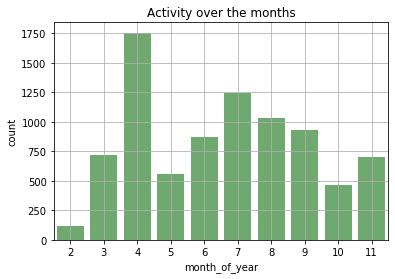

In [11]:
sns.countplot(df.month_of_year, color='green', alpha = 0.6)
plt.title('Activity over the months')
plt.grid()

In [12]:
df.head()

Text     Sender  \
0          Mazhar, Susandeep - welcome to students group       Babi   
1                                         Hello Everyone     Mazhar   
2  Are there any important updates if any, am I missing?     Mazhar   
3                                                Hi Babi  Susandeep   
4       I believe another group is also created for same  Susandeep   

   day_of_week  hour_of_day  month_of_year  
0            3           14              2  
1            3           14              2  
2            3           14              2  
3            3           15              2  
4            3           15              2

## Activity Heatmap

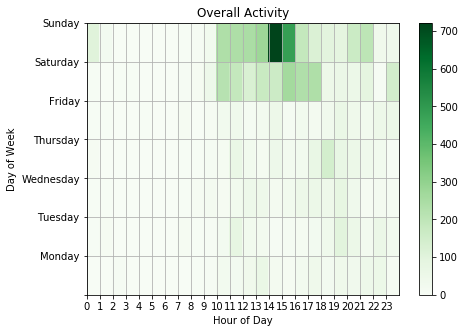

In [13]:
heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).size()
heatmap_data = heatmap_data.unstack()
heatmap_data = heatmap_data.fillna(0).astype('int16')

# Create heatmap
plt.figure(figsize=(7,5))
plt.pcolor(heatmap_data, cmap='Greens')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title('Overall Activity')
plt.xticks(np.arange(24))
plt.yticks(np.arange(8), ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.colorbar()
plt.show()

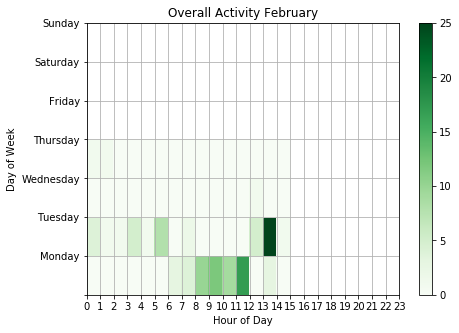

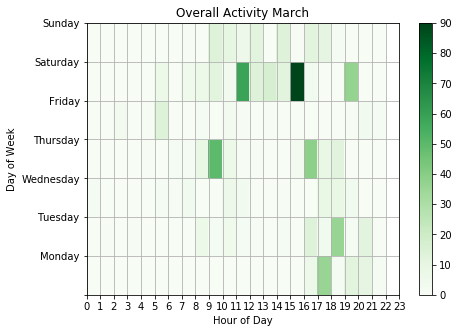

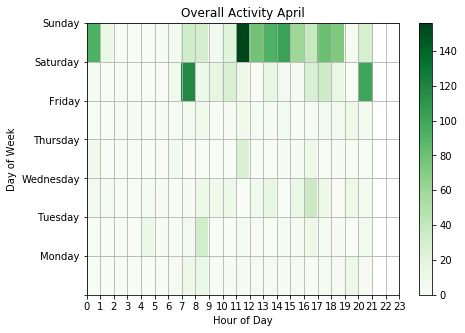

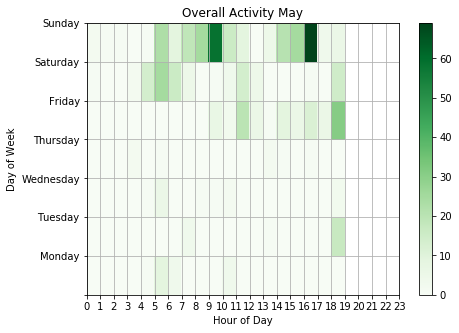

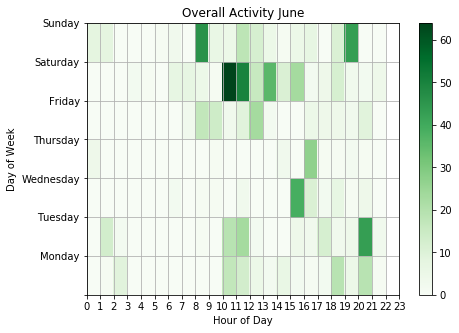

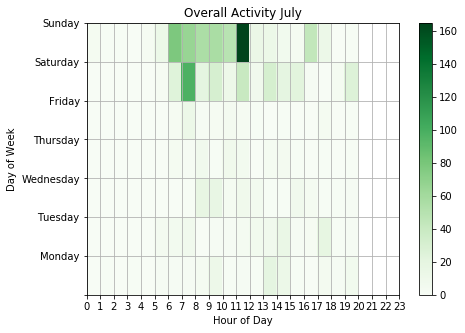

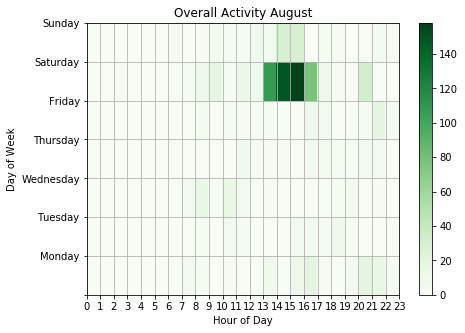

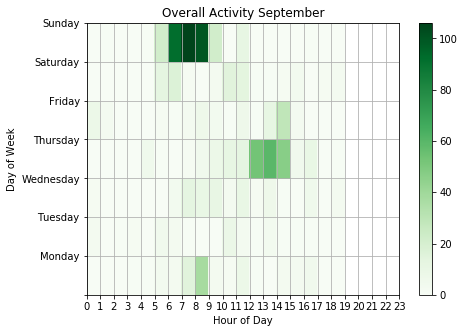

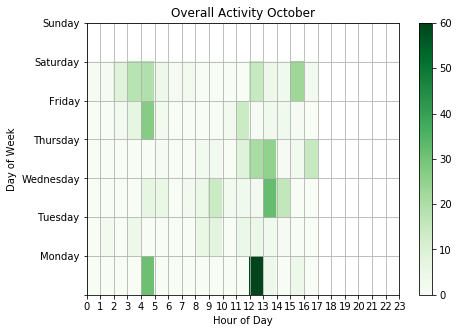

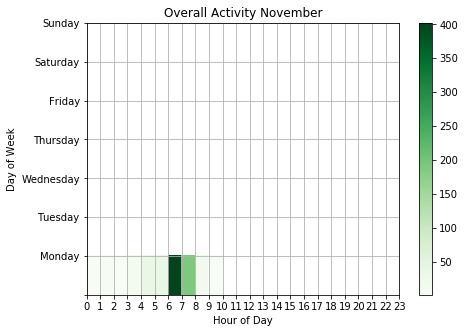

In [14]:
name_month = {2:"February", 3:"March", 4:"April", 5:"May",
              6:"June", 7:"July", 8:"August", 9:"September",
              10:"October", 11:"November"}

for month in df.month_of_year.unique():
    df_m = df[df['month_of_year'] == month]
    heat = df_m.groupby(['day_of_week', 'hour_of_day']).size()
    heat = heat.unstack()
    heat = heat.fillna(0).astype('int16')
    # heatmap_data

    # Create heatmap
    plt.figure(figsize=(7,5))
    plt.pcolor(heat, cmap='Greens')
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.title(f'Overall Activity {name_month[month]}')
    plt.xticks(np.arange(24))
    plt.yticks(np.arange(8), ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.grid()
    plt.colorbar()
    plt.show()

### Capturing count of texts send by each member

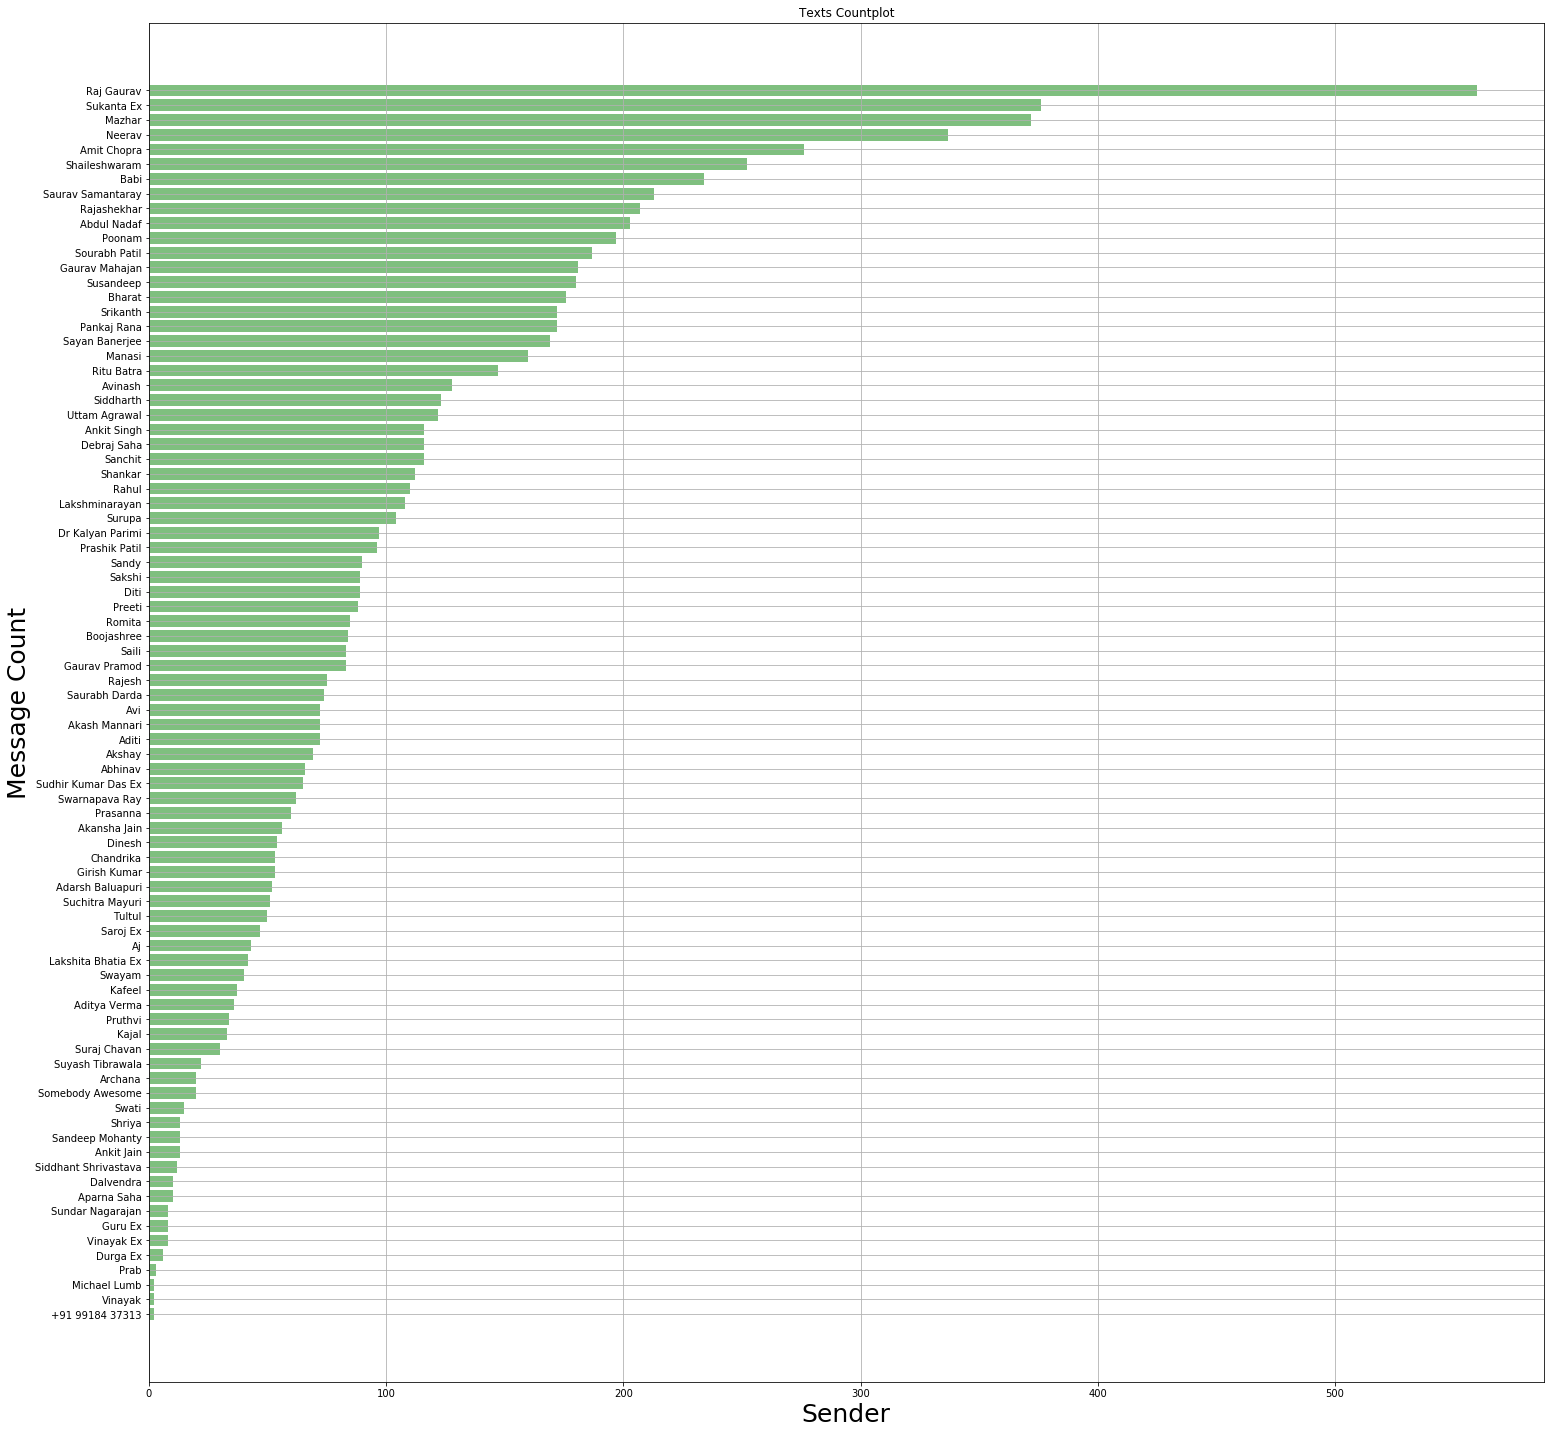

In [15]:
# Create sender counts as a series
sender_count_series = df.groupby(['Sender']).size().sort_values(ascending=True)

# Create sender counts series as a DataFrame
sender_count_df = pd.DataFrame(sender_count_series)

# Reset index in order to name columns correctly
sender_count_df = sender_count_df.reset_index()
sender_count_df.columns = ['Sender', 'count']

# Plot bar chart with sender message counts
plt.figure(figsize=(25, 25))
plt.barh(sender_count_df['Sender'], sender_count_df['count'], color='green', alpha = 0.5)
plt.title('Texts Countplot')
plt.xlabel("Sender", size=25)
plt.ylabel("Message Count", size=25)
plt.xticks(ha="center")
plt.grid(True)
plt.show()

sender_count_df = sender_count_df.sort_values('Sender', ignore_index=True)

In [16]:
text_count = {}
for ind, row in df.iterrows():
    sender = df.loc[ind, 'Sender']
    if sender in text_count:
        text_count[sender] += 1
    else:
        text_count[sender] = 1

Create corpus to hold all text send by individuals

In [17]:
# Dictionary to hold all text sent by individuals
member_text = {}

for sender in df.Sender.unique():
    member_text[sender] = ''
    
for ind, row in df.iterrows():
    text = df.loc[ind, 'Text']
    sender = df.loc[ind, 'Sender']
    member_text[sender] += ' ' + text
    member_text[sender] = member_text[sender].lower()

In [18]:
# member_text

In [19]:
member_text_df = pd.DataFrame({'Text':member_text})

member_text_df.head()

Text
+91 99184 37313                                                           thanks mazhar sure
Abdul Nadaf        thank you morning guys... can anyone help me... where in jlc can we fi...
Abhinav            agreed right let's write on the official group in which he messaged ju...
Adarsh Baluapuri   🤝🏻 facing proble in mysq installation problem* thanx can somebody tell...
Aditi              in the anaconda navigator, is it the jupyter lab that we need to launc...

Finding media-(images or gifs) in each message.  
Images appear as **<span><</span>Media omitted></span>**  
Example below:

In [20]:
member_text_df.iloc[8,0][:50]

' <media omitted> ? thanks <media omitted> 👍 then w'

Import custom function from my module to count media files

In [21]:
# from utils2 import media_count
def media_counter(text):
    pattern = '<Media omitted>'
    count = re.findall(pattern, text)
    return(len(count))

df['media_count'] = df.Text.apply(media_counter)
df.head()

Text     Sender  \
0          Mazhar, Susandeep - welcome to students group       Babi   
1                                         Hello Everyone     Mazhar   
2  Are there any important updates if any, am I missing?     Mazhar   
3                                                Hi Babi  Susandeep   
4       I believe another group is also created for same  Susandeep   

   day_of_week  hour_of_day  month_of_year  media_count  
0            3           14              2            0  
1            3           14              2            0  
2            3           14              2            0  
3            3           15              2            0  
4            3           15              2            0

In [22]:
Media_df = df.groupby(['Sender', 'media_count']).size().unstack()
Media_df.fillna(0, inplace=True)
Media_df = Media_df.astype('int32')
Media_df['Ratio%'] = round((Media_df[1]/Media_df[0])*100, ndigits=0)
Media_df['Ratio%'] = Media_df['Ratio%'].astype('int16')
Media_df.drop(0, axis = 1, inplace=True)
Media_df.sort_values(1, ascending=True, inplace=True)
Media_df.columns=['media_count', 'Ratio%media']
Media_df.reset_index(inplace=True)
Media_df = Media_df.sort_values('Sender', ignore_index=True)

In [23]:
count_df = pd.concat([sender_count_df, Media_df], axis=1,join='outer')
count_df = count_df.iloc[:,[0,1,3,4]]

In [24]:
count_df

Sender  count  media_count  Ratio%media
0    +91 99184 37313      2            0            0
1        Abdul Nadaf    203           17            9
2            Abhinav     66            7           12
3   Adarsh Baluapuri     52            2            4
4              Aditi     72            7           11
5       Aditya Verma     36           10           38
6                 Aj     43            8           23
7       Akansha Jain     56            6           12
8      Akash Mannari     72            5            7
9             Akshay     69           17           33
..               ...    ...          ...          ...
74            Surupa    104            7            7
75         Susandeep    180           30           20
76  Suyash Tibrawala     22            1            5
77    Swarnapava Ray     62            1            2
78             Swati     15            0            0
79            Swayam     40            2            5
80            Tultul     50            6           14
81     Uttam Agrawal    122           59           94
82           Vinayak      2            0            0
83        Vinayak Ex      8            0            0

[84 rows x 4 columns]

### Total msgs vs media messages

As seen some people are outliers, one person has has messages with over 90% images

In [25]:
fig = px.scatter(Media_df, x="Ratio%media", y="media_count",
                 hover_data=['Sender'], title='Images sent vs Messages sent')
fig.update_layout(title_font_color="green")
fig.show()

### Countplot for media files

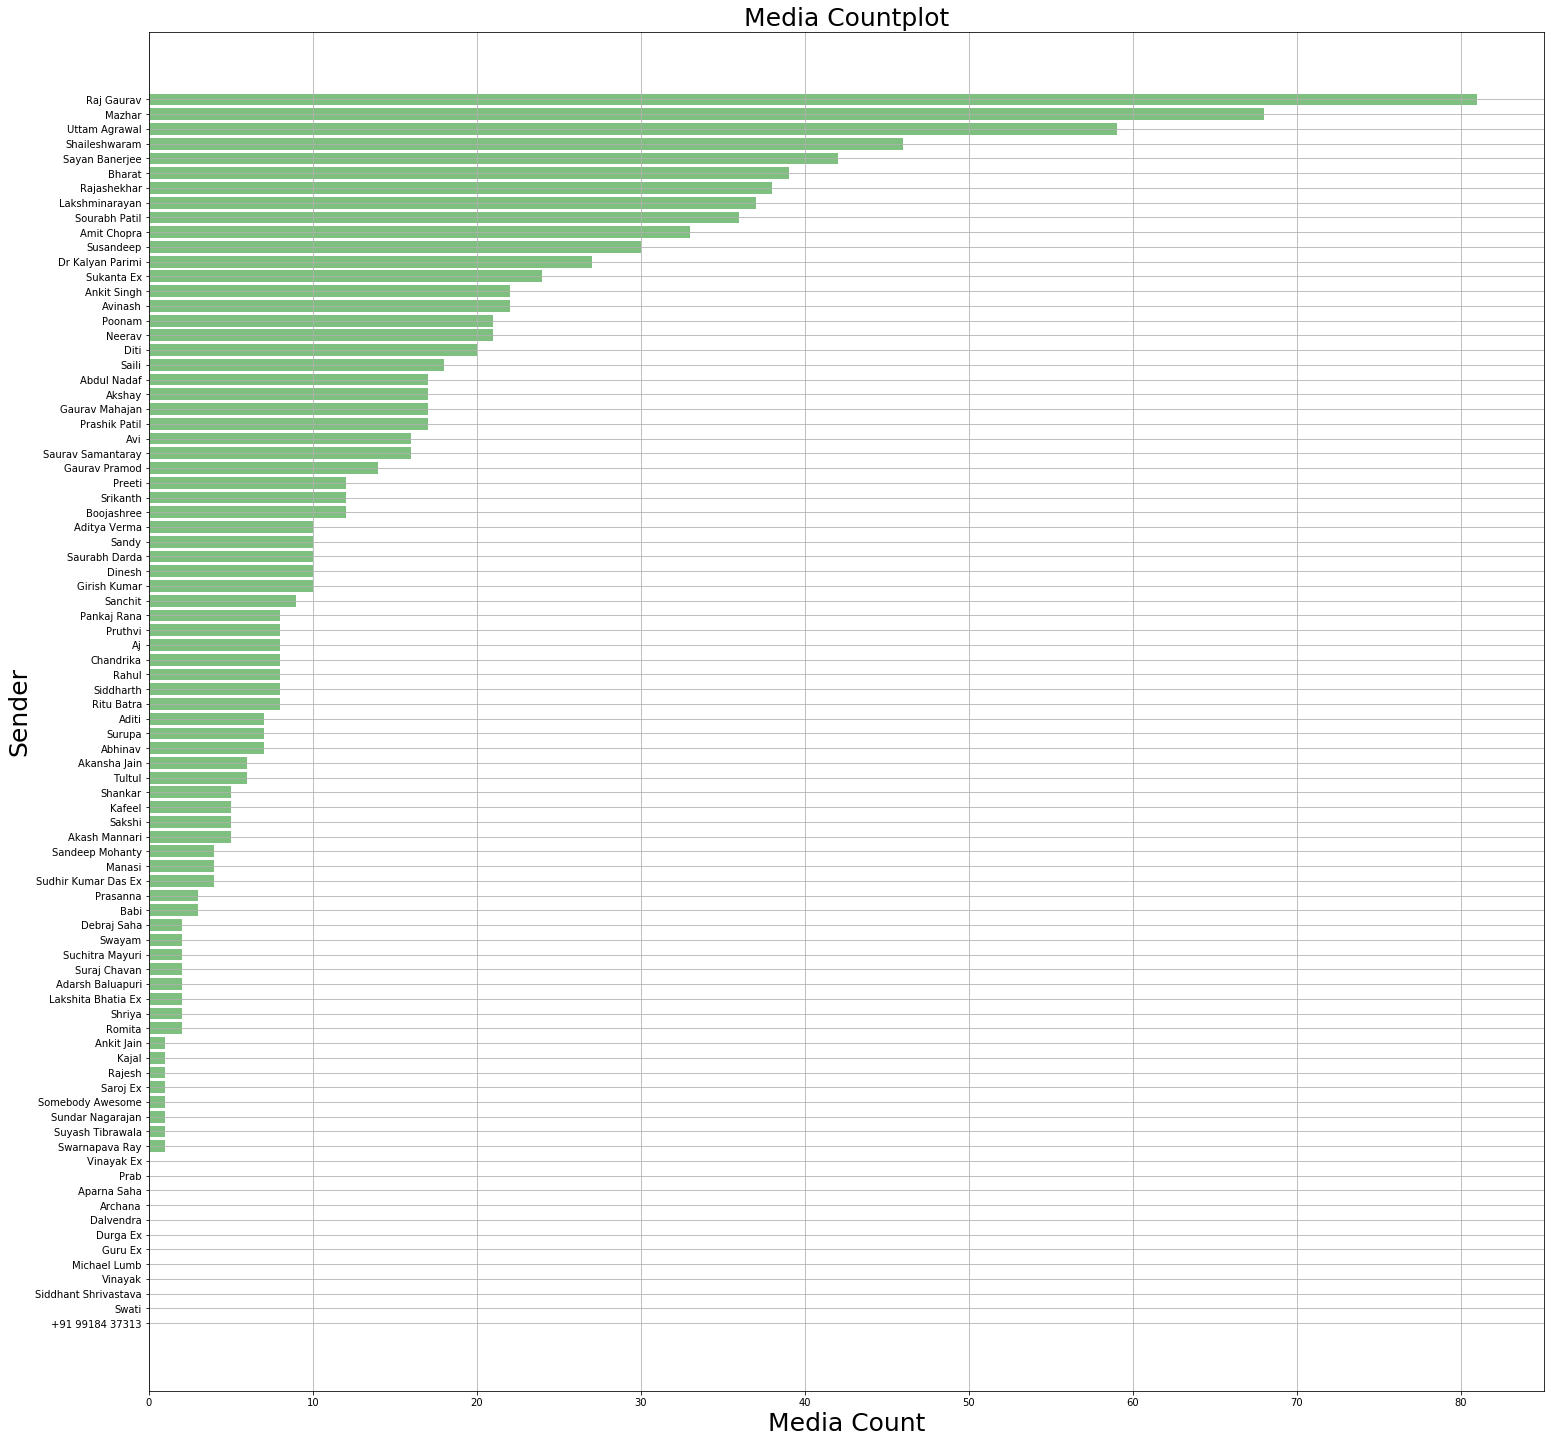

In [26]:
plt.figure(figsize=(25, 25))
plt.barh(Media_df.sort_values('media_count')['Sender'],
         Media_df.sort_values('media_count')['media_count'], color='green', alpha = 0.5)

plt.title('Media Countplot', size=25)
plt.ylabel("Sender", size=25)
plt.xlabel("Media Count", size=25)
plt.xticks(ha="center")
plt.grid(True)
plt.show()

## **Plot has incorrect scales** **Fix later

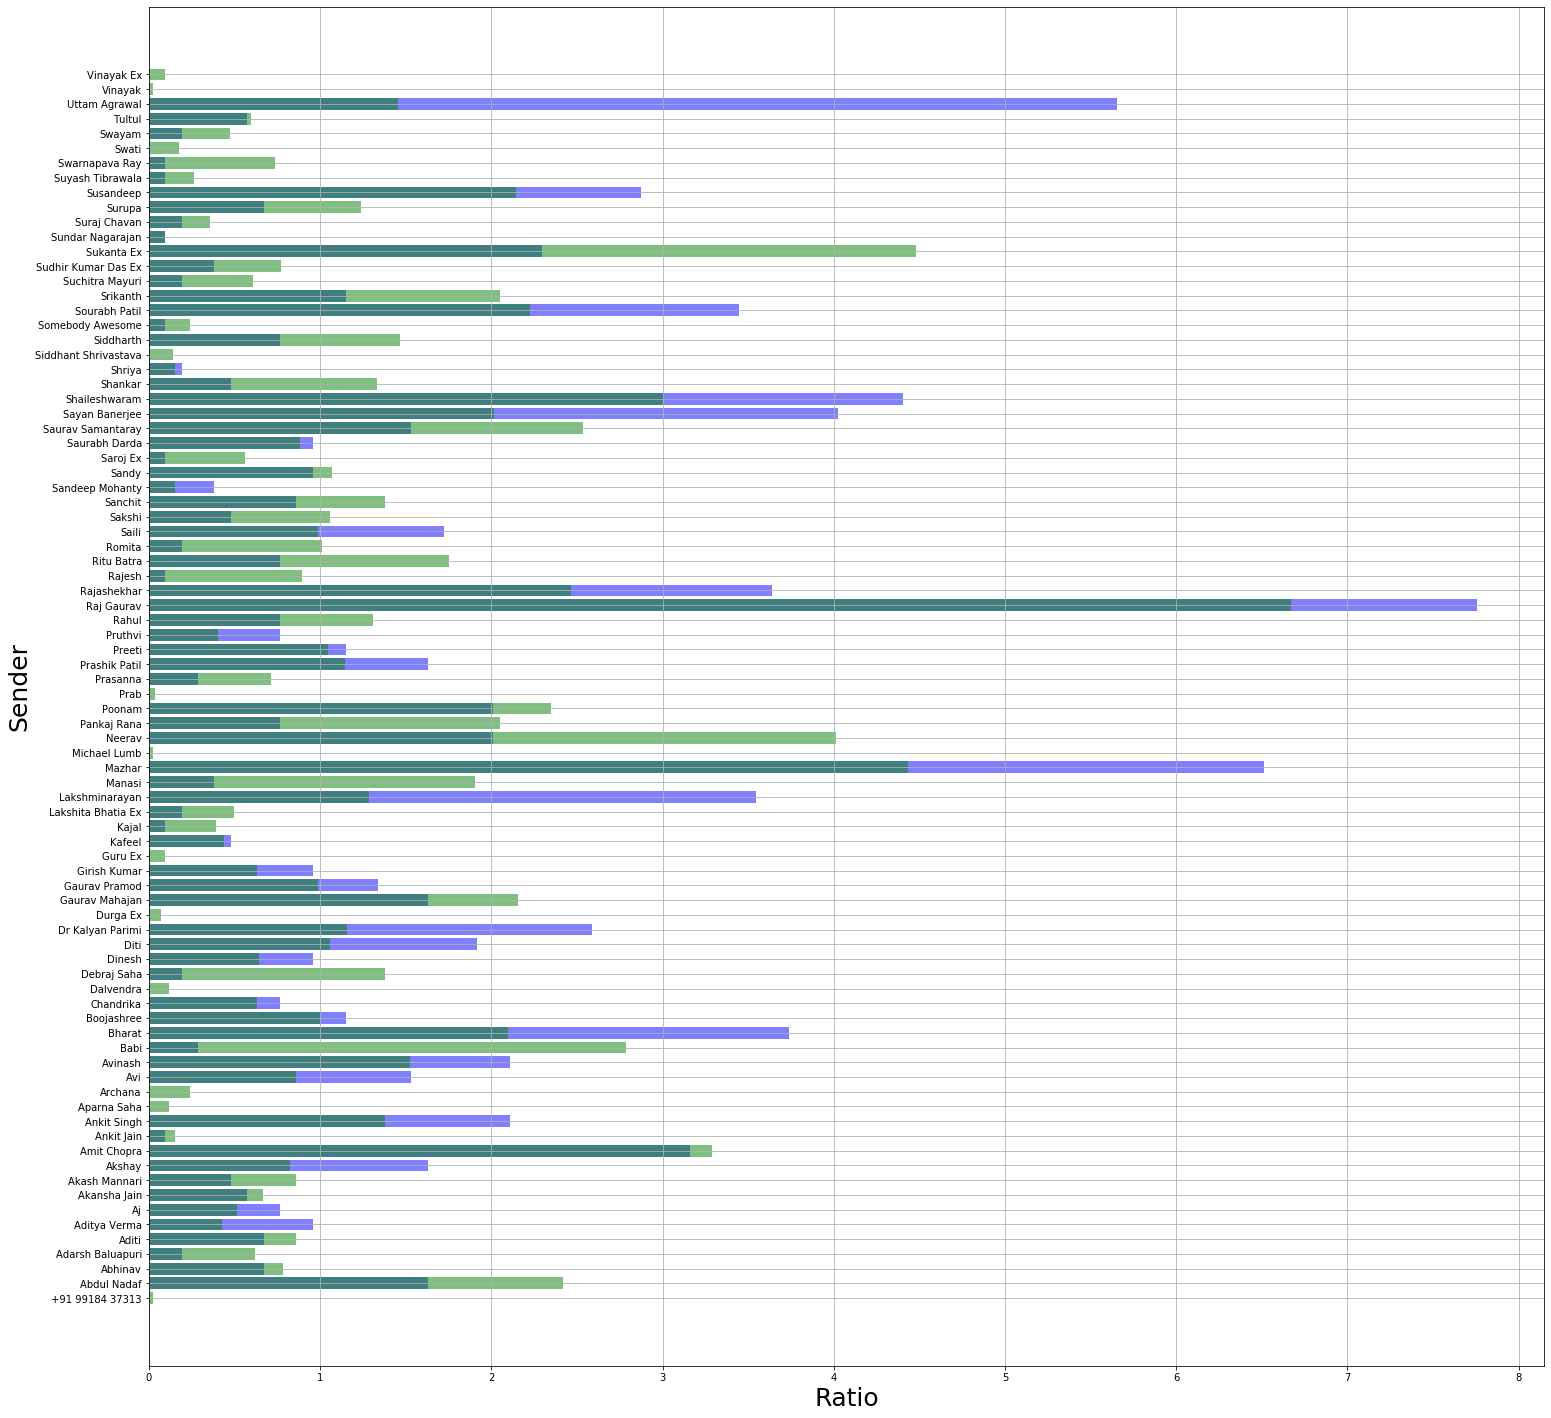

In [27]:
total_msgs = sender_count_df['count'].sum()
total_media = Media_df['media_count'].sum()
plt.figure(figsize=(25, 25))

plt.barh(Media_df['Sender'], Media_df['media_count']*100/total_media, color='blue', alpha=0.5)
plt.barh(sender_count_df['Sender'], sender_count_df['count']*100/total_msgs, color='green', alpha=0.5)
plt.ylabel("Sender", size=25)
plt.xlabel("Ratio", size=25)
plt.xticks(ha="center")
plt.grid(True)
plt.show()

In [28]:
count_df

Sender  count  media_count  Ratio%media
0    +91 99184 37313      2            0            0
1        Abdul Nadaf    203           17            9
2            Abhinav     66            7           12
3   Adarsh Baluapuri     52            2            4
4              Aditi     72            7           11
5       Aditya Verma     36           10           38
6                 Aj     43            8           23
7       Akansha Jain     56            6           12
8      Akash Mannari     72            5            7
9             Akshay     69           17           33
..               ...    ...          ...          ...
74            Surupa    104            7            7
75         Susandeep    180           30           20
76  Suyash Tibrawala     22            1            5
77    Swarnapava Ray     62            1            2
78             Swati     15            0            0
79            Swayam     40            2            5
80            Tultul     50            6           14
81     Uttam Agrawal    122           59           94
82           Vinayak      2            0            0
83        Vinayak Ex      8            0            0

[84 rows x 4 columns]

Emoji's sent by people

In [29]:
member_emoji_count={}
for key in member_text:
    member_emoji_count[key] = emoji.emoji_count(member_text[key])

emoji_df = pd.Series(member_emoji_count)
emoji_df = pd.DataFrame(emoji_df)
emoji_df.reset_index(inplace=True)
emoji_df.columns= ['Sender', 'emoji_count']
emoji_df.sort_values('Sender', inplace=True)
emoji_df.reset_index(inplace=True,drop=True)

In [30]:
count_df = pd.concat([count_df, emoji_df['emoji_count']], axis=1,join='outer')
count_df.head()

Sender  count  media_count  Ratio%media  emoji_count
0   +91 99184 37313      2            0            0            0
1       Abdul Nadaf    203           17            9           17
2           Abhinav     66            7           12            2
3  Adarsh Baluapuri     52            2            4            9
4             Aditi     72            7           11           23

### Emoji Use countplot

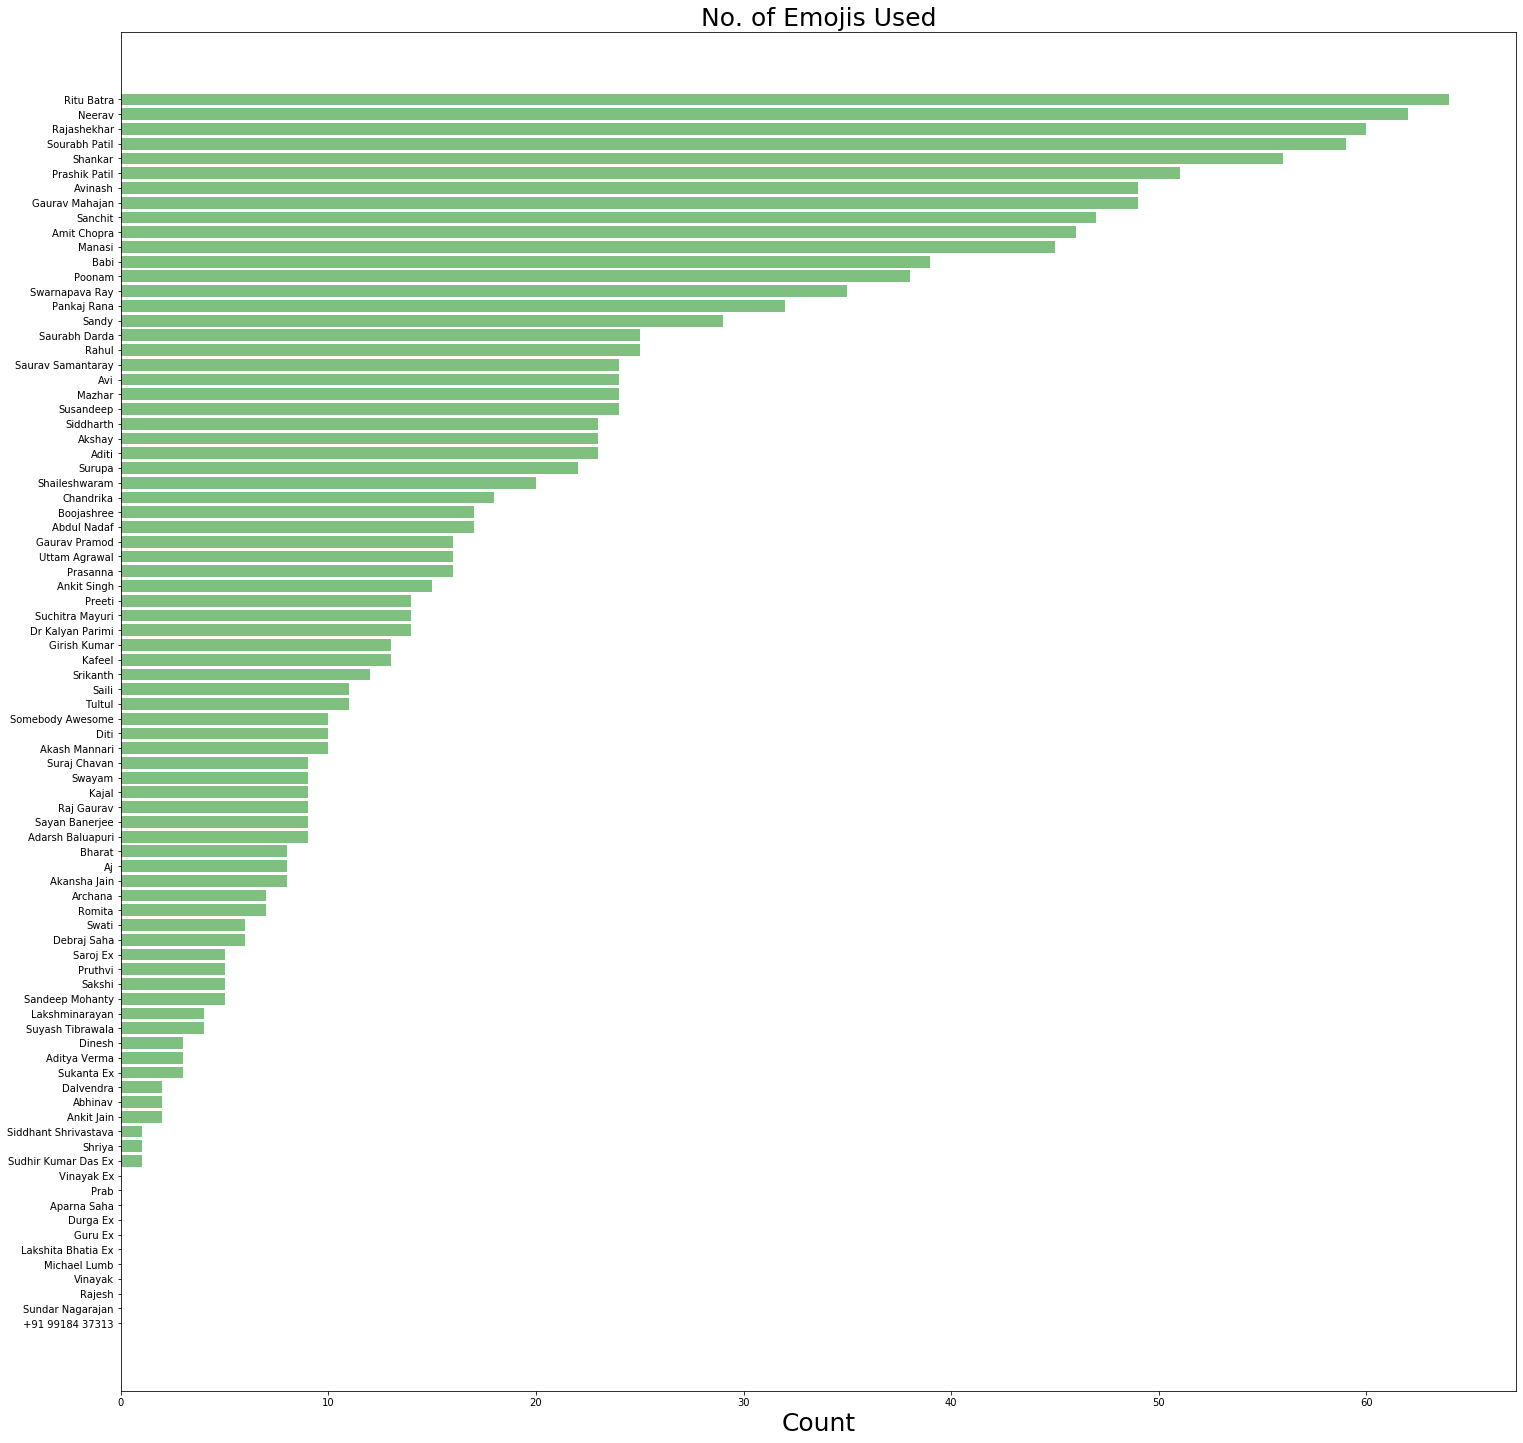

In [31]:
plt.figure(figsize=(25, 25))
plt.barh(count_df.sort_values('emoji_count')['Sender'], count_df.sort_values('emoji_count')['emoji_count'], color='green', alpha=0.5)
plt.title('No. of Emojis Used', size=25)
plt.xlabel('Count', size=25)
plt.show()

In [32]:
def extract_emojis(s):
      return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [33]:
df['Emojis'] = df.Text.apply(extract_emojis)

In [34]:
df.sample(4)

Text  \
4162                                                                           👍   
7742  So each question is 1 mark.. so should be easy only I guess.. anyways f...   
7711                                            Or shall we schedule a zoom call   
774                                                                   Yes it has   

             Sender  day_of_week  hour_of_day  month_of_year  media_count  \
4162  Sourabh Patil            6           11              7            0   
7742     Boojashree            7           12             11            0   
7711    Rajashekhar            7           12             11            0   
774      Raj Gaurav            7           14              3            0   

     Emojis  
4162      👍  
7742         
7711         
774

In [35]:
member_emoji_use = {}

for key in member_text:
    member_emoji_use[key] = ''
    
for ind, row in df.iterrows():
    member_emoji_use[row['Sender']] += df.loc[ind, 'Emojis']

In [36]:
member_emoji_use["Mazhar"]

'😇😐😂😦🙊😅🙌🏻😂😂😔✌😦🙏🏻🤩😯😖😂😂🤩😐🤞🏻'

In [37]:
count_df['emoji_unique'] = 0
for ind, row in count_df[1:].iterrows():
    emojis = member_emoji_use[row['Sender']]
    count_df.loc[ind, 'emoji_unique'] = len(set(emojis))

In [38]:
count_df.head()

Sender  count  media_count  Ratio%media  emoji_count  \
0   +91 99184 37313      2            0            0            0   
1       Abdul Nadaf    203           17            9           17   
2           Abhinav     66            7           12            2   
3  Adarsh Baluapuri     52            2            4            9   
4             Aditi     72            7           11           23   

   emoji_unique  
0             0  
1            12  
2             2  
3             7  
4             8

### Unique Emojis Used Countplot

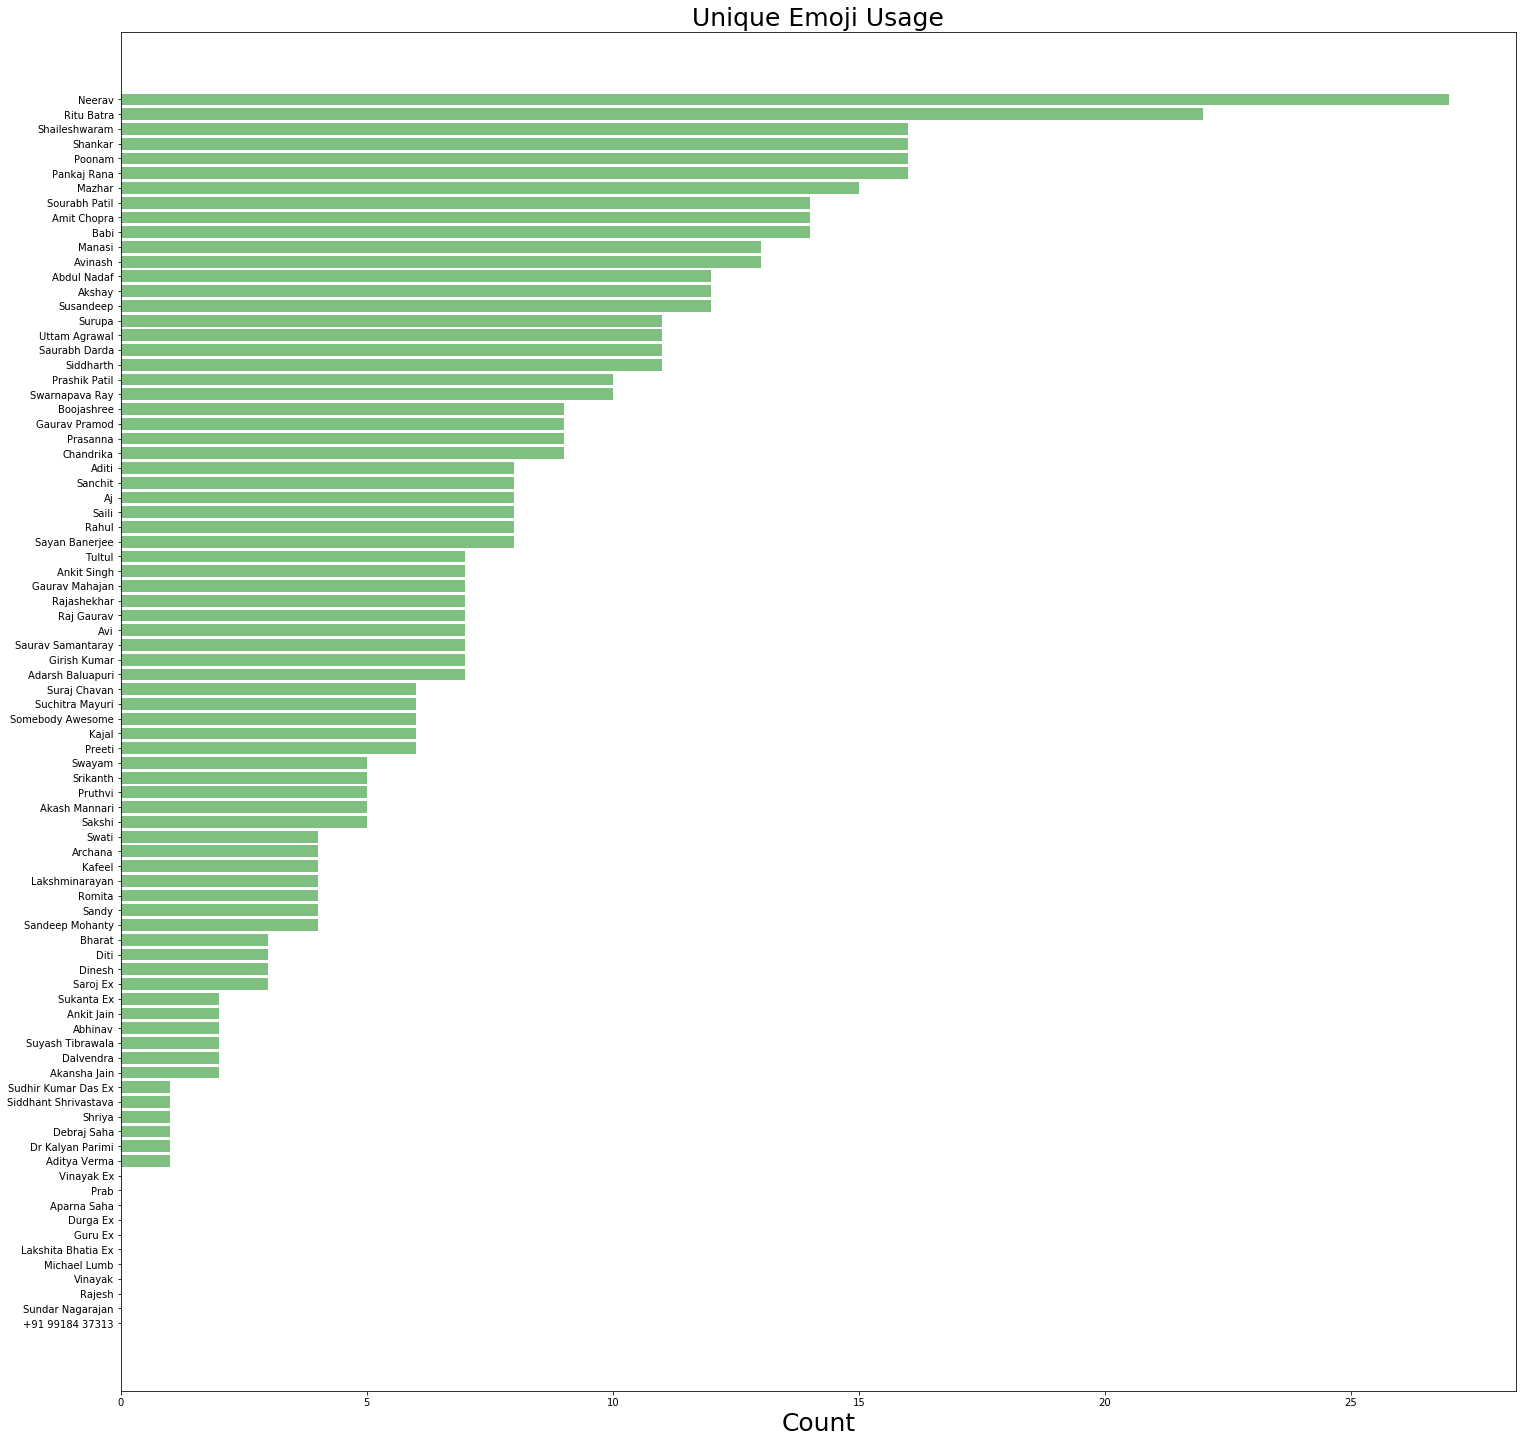

In [39]:
plt.figure(figsize=(25, 25))
plt.barh(count_df.sort_values('emoji_unique')['Sender'],
         count_df.sort_values('emoji_unique')['emoji_unique'], color='green', alpha=0.5)
plt.title("Unique Emoji Usage", size=25)
plt.xlabel('Count', size=25)
plt.show()

### Unique vs Total Emojis Sent

In [40]:
fig = px.scatter(count_df, x="emoji_count", y="emoji_unique",
                 hover_data=['Sender'], title='Unique vs Total Emojis Sent')
fig.update_layout(title_font_color="green")
fig.show()

In [41]:
count_df.emoji_count.sum()

1415

In [42]:
corpus = ''
for ind, row in df.iterrows():
    text = row['Text'] + " "
    corpus += text

corpus = corpus.lower()
print(f'Total words in corpus: {len(corpus)}')

Total words in corpus: 290812


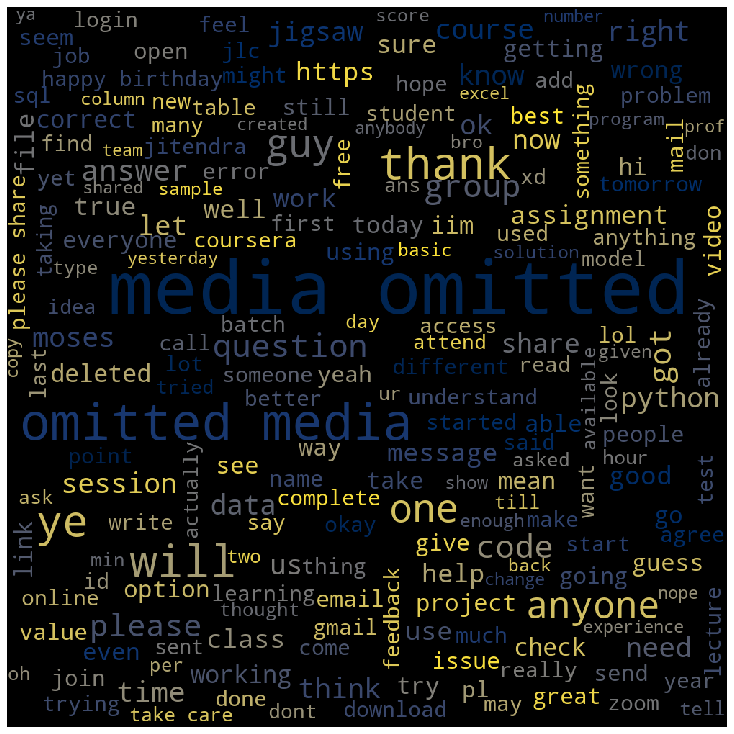

In [43]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 1000, height = 1000,
                      background_color ='black',
                      contour_color='white',
                      contour_width = 5,
                      stopwords = STOPWORDS,
                      min_font_size = 15,
                      colormap = 'cividis'
                     ).generate(corpus) 

# plot the WordCloud image                        
plt.figure(figsize = (10, 10)) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.imshow(wordcloud)
plt.show()

## Function for Wordclouds for a specific person

In [44]:
def user_wordcloud(name):
    wordcloud = WordCloud(width = 1000, height = 1000,
                      background_color ='black',
                      contour_color='white',
                      contour_width = 5,
                      stopwords = STOPWORDS,
                      min_font_size = 15,
                      colormap = 'cividis'
                         ).generate(member_text[name])

    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10)) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.imshow(wordcloud)
    plt.show()

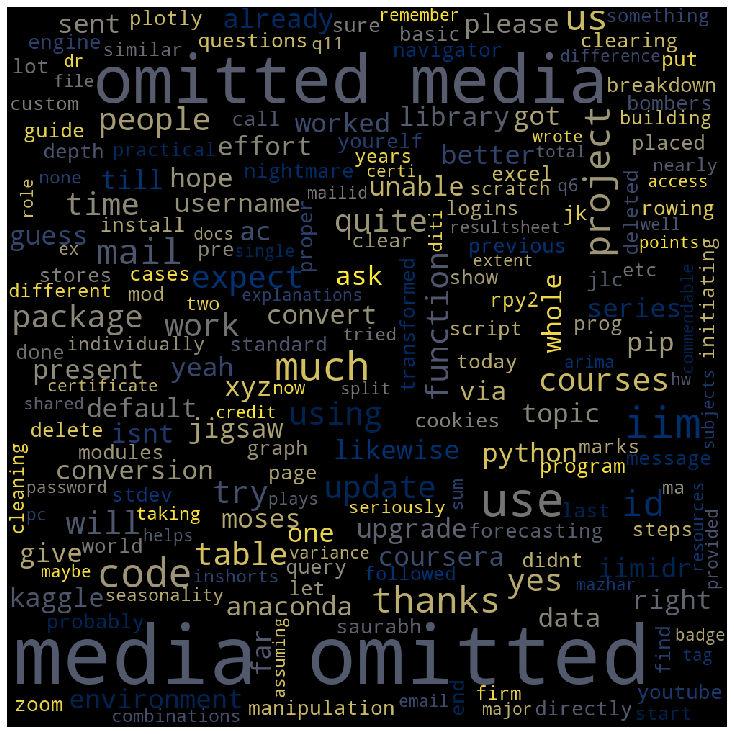

In [45]:
user_wordcloud('Dr Kalyan Parimi') ## Enter Name of anybody

In [46]:
# count_df.to_excel('count_df.xlsx', index=False)

------------
------------

Creating classes so each person can gather their own attributes

In [47]:
class data():
    member_wise_text = member_text
    corpus = corpus
    count_df = count_df
    
    def wordcloud(self, corpus = corpus):
        
        wordcloud = WordCloud(width = 1000, height = 1000,
                      background_color ='black',
                      contour_color='white',
                      contour_width = 5,
                      stopwords = STOPWORDS,
                      min_font_size = 15,
                      colormap = 'cividis'
                     ).generate(corpus) 

        # plot the WordCloud image                        
        plt.figure(figsize = (10, 10)) 
        plt.imshow(wordcloud)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.imshow(wordcloud)
        plt.show()

In [48]:
class my_info(data):
    member_text = member_text
    
    def __init__(self, name):
        self.name = name
    
    
    def user_wordcloud(self):
        wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color ='black',
                          contour_color='white',
                          contour_width = 5,
                          stopwords = STOPWORDS,
                          min_font_size = 15,
                          colormap = 'cividis'
                             ).generate(self.member_wise_text[self.name])

        # plot the WordCloud image                        
        plt.figure(figsize = (10, 10)) 
        plt.imshow(wordcloud)
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.imshow(wordcloud)
        plt.show()
        
    def emoji_stats():
        pass
    
    def media_stats():
        pass
    
    def activity_stats():
        pass

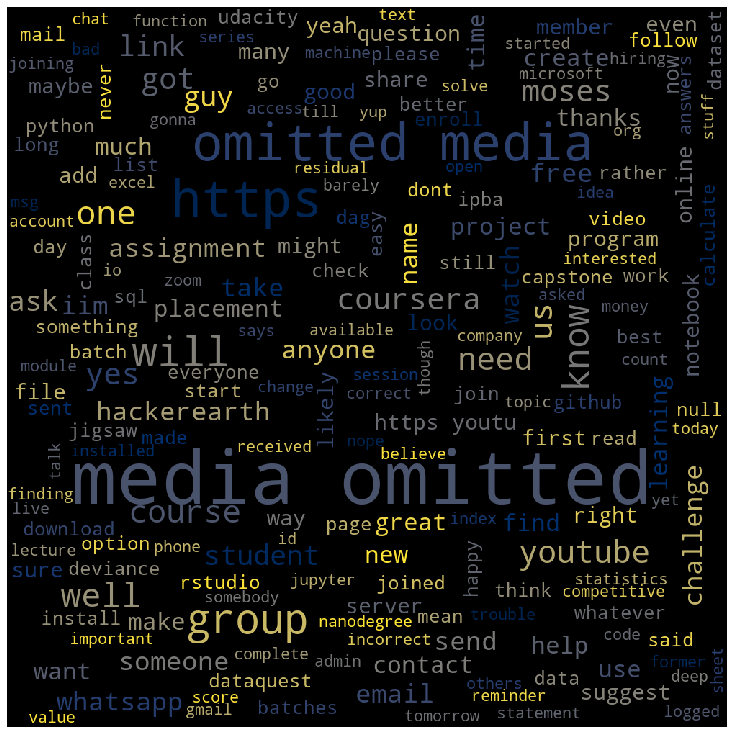

In [49]:
mazhar = my_info('Mazhar')
mazhar.user_wordcloud()